In [1]:
%matplotlib inline
import argparse
import glob
import logging
import os
import pickle
import random
import re
import csv
from typing import Dict, List, Tuple
import numpy as np
from scipy import stats
# from termcolor import colored
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import torch

In [6]:
def load_per_layer_influence(directory, test_idx, layer_i):
    per_layer_dict = torch.load(f"{directory}/influence_dict.pt")
    influence_list = per_layer_dict[layer_i][test_idx]
    return influence_list

In [7]:
with open("data/train.txt", "r") as file:
    train_examples = [line.strip() for line in file]
with open("data/unrolled_train.txt", "r") as file:
    unrolled_train_examples = [line.strip() for line in file]
with open("data/test.txt", "r") as file:
    test_examples = [line.strip() for line in file]
    
def see_example(data, idx):
    example = data[idx]
    correct, wrong = list(map(lambda x: x.split(), example.split("\t")))
    for c, w in zip(correct, wrong):
        if c != w:
            o = '  ||  '.join(example.split('\t'))
            print(f"{c} / {w}: {o}")
            return

def see_train_example(data, idx, mode='correct'):
    example = data[idx]
    correct, wrong = list(map(lambda x: x.split(), example.split("\t")))
    for c, w in zip(correct, wrong):
        if c != w:
            o = '  ||  '.join(example.split('\t'))
            if mode == 'incorrect':
                print(f"[{c}] / {w} (WRONG): {o}")
                return
            print(f"[{c}] / {w}: {o}")
            return
        
def see_example_key(data, idx, mode='correct'):
    example = data[idx]
    correct, wrong = list(map(lambda x: x.split(), example.split("\t")))
    for c, w in zip(correct, wrong):
        if c != w:
            return f"{c} / {w}"

In [8]:
see_example(test_examples, 0)

are / is: note that neckties are cut on the bias ( diagonally ) , so the stripes on the source cloth are parallel or perpendicular to the selvage , not diagonal .  ||  note that neckties are cut on the bias ( diagonally ) , so the stripes on the source cloth is parallel or perpendicular to the selvage , not diagonal .


In [9]:
see_train_example(train_examples, 64)

[are] / is: travelling backwards in time and travelling faster than the speed of light ( which i expect are the two things you are really asking about ) are essentially the same thing , according to general relativity ( just from a different point of view ) .  ||  travelling backwards in time and travelling faster than the speed of light ( which i expect is the two things you are really asking about ) are essentially the same thing , according to general relativity ( just from a different point of view ) .


In [10]:
see_train_example(train_examples, 3384)

[are] / is: the ruins of the abbey are open to the public and are privately owned .  ||  the ruins of the abbey is open to the public and are privately owned .


In [11]:
see_train_example(unrolled_train_examples, 0)

[is] / are: as a consequence of being mostly privately owned , the town is very opulently designed .  ||  as a consequence of being mostly privately owned , the town are very opulently designed .


In [12]:
see_train_example(unrolled_train_examples, 7000)

[are] / is: as a consequence of being mostly privately owned , the town are very opulently designed .  ||  as a consequence of being mostly privately owned , the town is very opulently designed .


### Show most influential training examples

In [13]:
def show_most_influential(directory, test_idx, mode='positive', per_layer=-1):
    if per_layer == -1:
        influence_list = pickle.load(open(f'{directory}/influence_test_idx_{test_idx}.pkl', 'rb'))
    else:
        influence_list = load_per_layer_influence(directory, test_idx, per_layer)
    if mode == 'positive':
        sorted_idx = np.argsort(influence_list)[::-1]
    elif mode == 'negative':
        sorted_idx = np.argsort(influence_list)
    else:
        raise ValueError('n/a')
    see_example(test_examples, test_idx)
    print()
    print("test idx:", test_idx, " -- most influential train idx:", sorted_idx[:10])
    print("################")
    for idx in sorted_idx[:10]:
        print()
        if 'unroll' in directory:
            if idx >= 7000:
                see_train_example(unrolled_train_examples, idx, mode='incorrect')
            else:
                see_train_example(unrolled_train_examples, idx, mode='correct')
        else:
            see_train_example(train_examples, idx)

In [79]:
def plot_most_influential(directory, test_idx, mode='positive', per_layer=-1):
    if per_layer == -1:
        influence_list = pickle.load(open(f'{directory}/influence_test_idx_{test_idx}.pkl', 'rb'))
    else:
        influence_list = load_per_layer_influence(directory, test_idx, per_layer)
    if mode == 'positive':
        sorted_idx = np.argsort(influence_list)[::-1]
    elif mode == 'negative':
        sorted_idx = np.argsort(influence_list)
    else:
        raise ValueError('n/a')
    see_example(test_examples, test_idx)
    test_key = see_example_key(test_examples, test_idx)
    print()
    print("test idx:", test_idx, " -- most influential train idx:", sorted_idx)
    print("################")
    correct_influence_ranks = []
    incorrect_influence_ranks = []
    for _i, idx in enumerate(sorted_idx):
        if 'unroll' in directory:
#             if set(see_example_key(unrolled_train_examples, idx).split(' / ')) != set(test_key.split(' / ')):
#                 continue
            if idx >= 7000:
                incorrect_influence_ranks.append(_i) # influence_list[idx]
            else:
                correct_influence_ranks.append(_i) # influence_list[idx]
        else:
            pass
    sns.distplot(correct_influence_ranks, label='correct')
    sns.distplot(incorrect_influence_ranks, label='incorrect')
    plt.legend()
    plt.show()

In [80]:
show_most_influential('unrolled_train_GC_outputs', 2, mode='positive')

are / is: safer alternatives are more expensive but are available .  ||  safer alternatives is more expensive but are available .

test idx: 2  -- most influential train idx: [11011 10581  9365  8960  7361 10640 10589  7193 11434 13124]
################

[are] / is (WRONG): the answer to all of the above questions are yes .  ||  the answer to all of the above questions is yes .

[are] / is (WRONG): the answer to both your questions are yes .  ||  the answer to both your questions is yes .

[are] / is (WRONG): the problem with previous contributions to articles are obvious .  ||  the problem with previous contributions to articles is obvious .

[are] / is (WRONG): see limit of a function for details on limits and why this order of operations are important .  ||  see limit of a function for details on limits and why this order of operations is important .

[are] / is (WRONG): a major reason why lists are preferred in some cases over categories are the ability to annotate .  ||  a major r

is / are: note that this list is not complete , as the episodes are scarce on the city names the expedition drove through .  ||  note that this list are not complete , as the episodes are scarce on the city names the expedition drove through .

test idx: 9  -- most influential train idx: [10964 11281 10902 ... 10640 11011  8960]
################


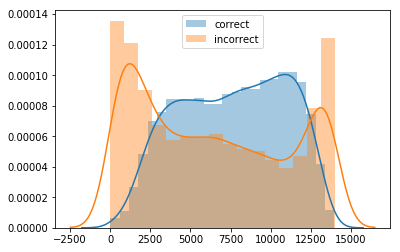

In [90]:
plot_most_influential('unrolled_train_GC_outputs', 9)

In [75]:
show_most_influential('init_GPT2_GC_outputs', 18, mode='positive', per_layer=-1) # 18 could be a good example comparing contra vs non-contra

has / have: according with the map of urban hierarchy of brazil , três pontas is classified as a center of zone b , that means the city has a small regional influence , restricted to small cities which três pontas is bordered .  ||  according with the map of urban hierarchy of brazil , três pontas is classified as a center of zone b , that means the city have a small regional influence , restricted to small cities which três pontas is bordered .

test idx: 18  -- most influential train idx: [4283 5686 4916 4462  598 1469  856 3683 1330  102]
################

[has] / have: the average faculty member has 16 years of experience .  ||  the average faculty member have 16 years of experience .

[has] / have: the village also has many wells .  ||  the village also have many wells .

[has] / have: this page has the cherokee syllabary .  ||  this page have the cherokee syllabary .

[has] / have: new system posting of the trains has arrival .  ||  new system posting of the trains have arrival .

In [49]:
show_most_influential('GC_per_layer_outputs', 0, mode='positive', per_layer=1)

are / is: note that neckties are cut on the bias ( diagonally ) , so the stripes on the source cloth are parallel or perpendicular to the selvage , not diagonal .  ||  note that neckties are cut on the bias ( diagonally ) , so the stripes on the source cloth is parallel or perpendicular to the selvage , not diagonal .

test idx: 0  -- most influential train idx: [5040  475 5589 5229 4207 1028 3384 1974 5272 6115]
################

[begin] / begins: the creatures begin to crawl back into the lake , where they disappear under the water .  ||  the creatures begins to crawl back into the lake , where they disappear under the water .

[are] / is: i agree with some of the other reviewers here ; some areas of this article are well-done but some are not .  ||  i agree with some of the other reviewers here ; some areas of this article is well-done but some are not .

[are] / is: things which are equal to the same thing are also equal to one another .  ||  things which are equal to the same thin

In [2]:
for test_idx in range(0, 20):
    influence_list = pickle.load(open(f'GC_outputs/influence_test_idx_{test_idx}.pkl', 'rb'))
    print("test idx:", test_idx, " -- most influential train idx:", np.argsort(influence_list)[::-1][:10])

test idx: 0  -- most influential train idx: [  64 3384 4935 5589 5104  135 6525 3810 3904 3639]
test idx: 1  -- most influential train idx: [ 300 3430 4990 1754  626 5086 3964 5361 4143 2092]
test idx: 2  -- most influential train idx: [  64 3384 5589 5309 4872 1795 4935 4127 3639 4176]
test idx: 3  -- most influential train idx: [2239 2617 5428 4896 3002 3776 3347 1607 5741 1870]
test idx: 4  -- most influential train idx: [6776 5981 1816 4243 4139  919 6011 2274 1404 5247]
test idx: 5  -- most influential train idx: [4284 1444 1814 3768 3433 5188 5920 2359 4994 4627]
test idx: 6  -- most influential train idx: [ 300 3430 4990 1754 5361 3964 5086 2092  626 6927]
test idx: 7  -- most influential train idx: [  64 3384 4176 2171 4872 5970  991 4127 4274 5589]
test idx: 8  -- most influential train idx: [  64 1960 3384 3810 3639 4872 5970 4935 4176  645]
test idx: 9  -- most influential train idx: [ 300 3430 1754 4990 5086 5361 3964 2092 1630 4143]
test idx: 10  -- most influential train 

In [3]:
for test_idx in range(0, 20):
    influence_list = pickle.load(open(f'GC_nocontra_outputs/influence_test_idx_{test_idx}.pkl', 'rb'))
    print("test idx:", test_idx, " -- most influential train idx:", np.argsort(influence_list)[::-1][:10])

test idx: 0  -- most influential train idx: [3099 3917   91 3179 5723 1452 1061 3414 4338  315]
test idx: 1  -- most influential train idx: [5374 4956 4757  170 6346 3383 2486 6289 5421 1700]
test idx: 2  -- most influential train idx: [  11 5932 4681 1795 4176 3977 2171 2095 4274 6779]
test idx: 3  -- most influential train idx: [5605 2417 6322 4293  498 1097 4492 5878 3469  572]
test idx: 4  -- most influential train idx: [4766 6011 6526 5981 5581 4094 6227 2959 6720   36]
test idx: 5  -- most influential train idx: [5863   52 3582 6886 6072 6743 5352 6128   54 6786]
test idx: 6  -- most influential train idx: [3105 3202 6730 2252  635 2681  388  576 3480 6633]
test idx: 7  -- most influential train idx: [3492 1346 2800 6525 5053 3059 4157  620 4432 2990]
test idx: 8  -- most influential train idx: [ 192 6965 4511 4621 1764 6680 6438 2663 5963 4942]
test idx: 9  -- most influential train idx: [3099  576 3074 2589 3046 2070 5450 6157  486 4381]
test idx: 10  -- most influential train 

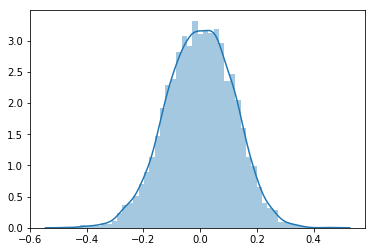

In [4]:
test_idx = 0

influence_list = pickle.load(open(f'GC_outputs/influence_test_idx_{test_idx}.pkl', 'rb'))
sns.distplot(influence_list)

In [5]:
test_idx_lb = 0
test_idx_ub = 20
influence_file_dir = 'GC_outputs/'

top_1_inf_ex_set = set()
top_10_inf_ex_set = set()

for test_idx in range(test_idx_lb, test_idx_ub):
    influence_list = pickle.load(open(f'{influence_file_dir}influence_test_idx_{test_idx}.pkl', 'rb'))
    inf_sorted_idx = list(np.argsort(influence_list))
    inf_sorted_idx.reverse()
    for _i, isi in enumerate(inf_sorted_idx):
        if _i < 1:
            top_1_inf_ex_set.add(isi)
        if _i < 10:
            top_10_inf_ex_set.add(isi)

print('Top-1 set cardinality:', len(top_1_inf_ex_set), f'({test_idx_ub - test_idx_lb} test examples)')
print('Top-10 set cardinality:', len(top_10_inf_ex_set), f'({test_idx_ub - test_idx_lb} test examples)')

Top-1 set cardinality: 11 (20 test examples)
Top-10 set cardinality: 120 (20 test examples)


In [6]:
test_idx_lb = 0
test_idx_ub = 20
influence_file_dir = 'GC_nocontra_outputs/'

top_1_inf_ex_set = set()
top_10_inf_ex_set = set()

for test_idx in range(test_idx_lb, test_idx_ub):
    influence_list = pickle.load(open(f'{influence_file_dir}influence_test_idx_{test_idx}.pkl', 'rb'))
    inf_sorted_idx = list(np.argsort(influence_list))
    inf_sorted_idx.reverse()
    for _i, isi in enumerate(inf_sorted_idx):
        if _i < 1:
            top_1_inf_ex_set.add(isi)
        if _i < 10:
            top_10_inf_ex_set.add(isi)

print('Top-1 set cardinality:', len(top_1_inf_ex_set), f'({test_idx_ub - test_idx_lb} test examples)')
print('Top-10 set cardinality:', len(top_10_inf_ex_set), f'({test_idx_ub - test_idx_lb} test examples)')

Top-1 set cardinality: 19 (20 test examples)
Top-10 set cardinality: 193 (20 test examples)
